In [1]:
%load_ext jupyter_black

In [2]:
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [25]:
class HRRR:
    type_of_level = [
        # {"typeOfLevel": "hybrid"},
        # {"typeOfLevel": "depthBelowLandLayer"},
        {"typeOfLevel": "atmosphere"},
        {"typeOfLevel": "cloudTop"},
        {"typeOfLevel": "surface"},
        {"typeOfLevel": "heightAboveGround"},
        {"typeOfLevel": "isothermal"},
        {"typeOfLevel": "pressureFromGroundLayer"},
        {"typeOfLevel": "sigmaLayer"},
        {"typeOfLevel": "meanSea"},
        {"typeOfLevel": "isobaricInhPa"},
        {"typeOfLevel": "heightAboveGroundLayer"},
        {"typeOfLevel": "sigma"},
        {"typeOfLevel": "atmosphereSingleLayer", "stepType": "max"},
        {"typeOfLevel": "atmosphereSingleLayer", "stepType": "instant"},
        {"typeOfLevel": "depthBelowLand"},
        {"typeOfLevel": "isobaricLayer"},
        {"typeOfLevel": "lowCloudLayer"},
        {"typeOfLevel": "middleCloudLayer"},
        {"typeOfLevel": "highCloudLayer"},
        {"typeOfLevel": "cloudCeiling"},
        {"typeOfLevel": "cloudBase"},
        {"typeOfLevel": "nominalTop"},
        {"typeOfLevel": "isothermZero"},
        {"typeOfLevel": "highestTroposphericFreezing"},
        {"typeOfLevel": "adiabaticCondensation"},
        {"typeOfLevel": "equilibrium"},
        {"typeOfLevel": "unknown"},
    ]

    def __init__(self, files: list[str]) -> None:
        self._file_list = files

    def _filter_by_level(level: str, **kwargs):

        filter_by_keys = {"typeOfLevel": level} | kwargs

        def key_filter(self: "HRRR"):
            def generate():
                for filepath in self._file_list:
                    ds: xr.Dataset = xr.open_dataset(filepath, engine="cfgrib", filter_by_keys=filter_by_keys)
                    if {"latitude", "longitude", "valid_time"}.issubset(ds.coords):
                        yield ds.drop_vars(
                            coord for coord in ds.coords if coord not in ("latitude", "longitude", "valid_time")
                        )

            return xr.concat(generate(), dim="valid_time")

        return lambda _: key_filter

    @property
    @_filter_by_level("atmosphere")
    def atmosphere(self) -> xr.Dataset:
        """
        coordinates:
            - latitude
            - longitude
            - valid_time

        Data variables:
            - refc: Maximum/Composite radar reflectivity
        """

    @property
    @_filter_by_level("hybrid")
    def hybrid(self) -> xr.Dataset:
        """caution long loads probably needs a dask solution"""

    @property
    @_filter_by_level("equilibrium")
    def equilibrium(self) -> xr.Dataset:
        ...

    @property
    @_filter_by_level("cloudTop")
    def cloud_top(self) -> xr.Dataset:
        ...

    @property
    @_filter_by_level("heightAboveGround")
    def height_above_ground(self) -> xr.Dataset:
        ...

    @property
    @_filter_by_level("isothermal", stepType="max")
    def isothermal(self) -> xr.Dataset:
        ...


def open_files(files: list[str]) -> HRRR:
    return HRRR(files if isinstance(files, list) else [files])


hrrr = open_files(glob("/workspaces/griblib/data/hrrr/*.grib"))

In [4]:
df = hrrr.isothermal.to_dataframe()
df

latitude   longitude    refd
y    x    valid_time                                        
0    0    2022-06-17 09:00:00  21.138123  237.280472  0.0000
          2022-06-17 13:00:00  21.138123  237.280472  0.0000
          2022-06-17 05:00:00  21.138123  237.280472  0.0000
          2022-06-17 14:00:00  21.138123  237.280472  0.0000
          2022-06-17 04:00:00  21.138123  237.280472  0.0000
...                                  ...         ...     ...
1058 1798 2022-06-17 01:00:00  47.842195  299.082807  0.0000
          2022-06-17 08:00:00  47.842195  299.082807  0.0000
          2022-06-17 10:00:00  47.842195  299.082807  2.5000
          2022-06-17 11:00:00  47.842195  299.082807  4.9375
          2022-06-17 03:00:00  47.842195  299.082807  0.0000

[28577115 rows x 3 columns]

<GeoAxesSubplot:xlabel='longitude', ylabel='latitude'>

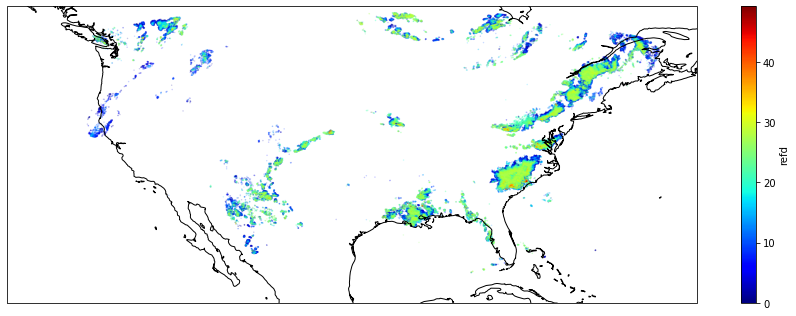

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

idx: slice = pd.IndexSlice

plt.rcParams["axes.grid"] = True

ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())

valid_times = df.index.unique("valid_time").sort_values()
ax.coastlines("50m")

ax.set_extent(
    [
        *df["longitude"].agg(["min", "max"]),
        *df["latitude"].agg(["min", "max"]),
    ],
    ccrs.PlateCarree(),
)
df0 = df.loc[idx[:, :, valid_times[0]], :]

df0.plot(
    kind="scatter",
    y="latitude",
    x="longitude",
    c="refd",
    ax=ax,
    alpha=np.where(df0["refd"] > 0, 0.2, 0),
    cmap=plt.get_cmap("jet"),
    s=0.25,
    figsize=(16, 12),
)

In [7]:
import pandas as pd

# in most cases setting the valid_time , latitude , longitude makes the most sense
def normalize_index(df: pd.DataFrame) -> pd.DataFrame:
    df["valid_time"] = df.time + df.step
    return df.drop(["time", "step"], axis=1).set_index(["valid_time", "latitude", "longitude"])


# using the pipe method keeps
ds.to_dataframe().pipe(normalize_index)

NameError: name 'ds' is not defined

In [ ]:
df = ds.to_dataframe()
df["longitude"] = (df["longitude"] + 180) % 360 - 180
# df.plot()

<GeoAxesSubplot:xlabel='longitude', ylabel='latitude'>

/opt/venv/lib/python3.10/site-packages/Cartopy-0.20.2-py3.10-linux-x86_64.egg/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


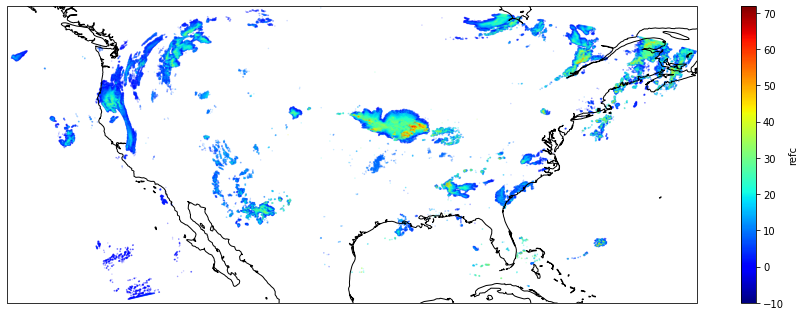

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np


plt.rcParams["axes.grid"] = True

ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())

ax.coastlines("50m")

ax.set_extent(
    [
        *df["longitude"].agg(["min", "max"]),
        *df["latitude"].agg(["min", "max"]),
    ],
    ccrs.PlateCarree(),
)

df.plot(
    kind="scatter",
    y="latitude",
    x="longitude",
    c="refc",
    ax=ax,
    alpha=np.where(df["refc"] > 0, 0.2, 0),
    cmap=plt.get_cmap("jet"),
    s=0.25,
    figsize=(16, 12),
)

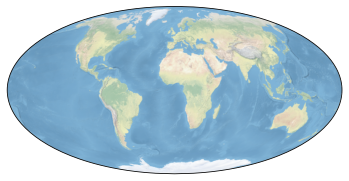

In [ ]:
ax = plt.axes(projection=ccrs.Mollweide())
ax.stock_img()
plt.show()

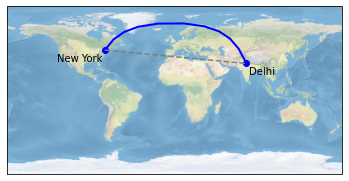

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

ny_lon, ny_lat = -75, 43
delhi_lon, delhi_lat = 77.23, 28.61

plt.plot(
    [ny_lon, delhi_lon],
    [ny_lat, delhi_lat],
    color="blue",
    linewidth=2,
    marker="o",
    transform=ccrs.Geodetic(),
)

plt.plot(
    [ny_lon, delhi_lon],
    [ny_lat, delhi_lat],
    color="gray",
    linestyle="--",
    transform=ccrs.PlateCarree(),
)

plt.text(ny_lon - 3, ny_lat - 12, "New York", horizontalalignment="right", transform=ccrs.Geodetic())

plt.text(delhi_lon + 3, delhi_lat - 12, "Delhi", horizontalalignment="left", transform=ccrs.Geodetic())

plt.show()